In [5]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle
import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model
import keras.backend as K

from lib.utils import load_gtsrb

from lib.lib_knn import *
from lib.knn_attack import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

from scipy.spatial.distance import cosine
import timeit
import falconn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(1234)

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:, :, :, np.newaxis] / 255.
X_test = X_test[:, :, :, np.newaxis] / 255.
# y_train = y_train[:, np.newaxis]
# y_test = y_test[:, np.newaxis]
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.1)

In [4]:
X_train_nm = X_train/np.sqrt(np.sum(X_train**2, axis=(1, 2, 3), keepdims=True))
X_test_nm = X_test/np.sqrt(np.sum(X_test**2, axis=(1, 2, 3), keepdims=True))
X_train_nm = X_train_nm.reshape(-1, 784)
X_test_nm = X_test_nm.reshape(-1, 784)

In [5]:
def compute_cosine(u, v):
    """
    Asssume normalized inputs
    """
    assert u.ndim >= v.ndim
    v_rs = v.reshape(-1)
    if u.ndim > v.ndim:
        u_rs = u.reshape(len(u), -1)
#         cdist = np.array([cosine(u_i, v_rs) for u_i in u_rs])
        cdist = np.array([1 - np.dot(u_i, v_rs) for u_i in u_rs])
    else:
        u_rs = u.reshape(-1)
#         cdist = cosine(u_rs, v_rs)
        cdist = 1 - np.dot(u_rs, v_rs)
    return cdist


def find_nn(Q, X, k):
    assert Q.shape[1:] == X.shape[1:]
    nn = np.zeros((len(Q), k), dtype=np.int32)
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    for i, q in enumerate(Q):
        ind = np.argsort(compute_cosine(X, q))[:k]
        nn[i] = ind
    return nn


def classify(nn, y_X):
    vote = np.array([np.argmax(np.bincount(y)) for y in y_X[nn]])
    return vote


def find_acc(nn, y_Q, y_X):
    vote = classify(nn, y_X)
    print(np.mean(vote == y_Q))
    
    
def find_nn_diff_class(Q, y_Q, X, y_X, k):
    target = np.zeros((len(Q), k), dtype=np.int32)
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    for i, (q, y_q) in enumerate(zip(Q, y_Q)):
        ind = np.argsort(compute_cosine(X, q))
        target[i] = ind[y_X[ind] != y_q][:k]
    return target


def move_to_target(q, y_q, target, X, y_X, k, n_steps=5):
    """
    Move in straight line to target with binary search.
    Stop when adv is misclassified.
    """
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    line = target - q
    hi = 1
    lo = 0
    adv = None
    for step in range(n_steps):
        mid = (hi + lo)/2
        x_new = mid*line + q
        new_neighbors = np.argsort(np.sum((X - x_new)**2, axis=axis))[:k]
        y_pred = np.argmax(np.bincount(y_X[new_neighbors]))
        if y_pred == y_q:
            lo = mid
        else:
            hi = mid
            adv = x_new
    return adv
            
    
def attack_v2(Q, y_Q, X, y_X, k, n_steps=5):
    """
    Naive attack v2 (untargeted): 
    Complexity is O(k * n_X log (n_X) * n_Q * n_steps)
    
    1. Choose trianing sample of target class from X closest to query
    2. Find closest sample of the same class to the mean of K
    3. Add that sample to K
    4. Repeat 2. - 3. until |K| = k/2 + 1
    5. Move query closer to mean of K, terminate when query becomes
       adversarial
    """
    
    nn = find_nn_diff_class(Q, y_Q, X, y_X, 1)
    X_adv = np.zeros_like(Q)
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    
    for i, (q, y_q) in enumerate(zip(Q, y_Q)):
        
        if i % 200 == 0:
            print(i)
        
        n_neighbors = int(np.floor(k/2) + 1)
        K = np.zeros((n_neighbors, ) + Q.shape[1:])
                    
        # Step 1.
        K[0] = X[nn[i, 0]]
        K_ind = [nn[i, 0]]

        for j in range(1, n_neighbors):
            
            # Step 2.
            mean = np.mean(K[:j], axis=0)
            ind = np.argsort(np.sum((X - mean)**2, axis=axis))
            new_nbs = ind[y_X[ind] != y_q]
            
            # Step 3.
            for new_nb in new_nbs:
                if new_nb not in K_ind:
                    K_ind.append(new_nb)
                    K[j] = X[new_nb]
                    break
                    
        # Step 5.
        mean = np.mean(K, axis=0)
        X_adv[i] = move_to_target(q, y_q, mean, X, y_X, k, n_steps)
        
    return X_adv

Choosing k, l, num_probe: https://github.com/FALCONN-LIB/FALCONN/wiki/LSH-Primer

In [6]:
def setup_lsh(X, num_probes=100):
    assert X.ndim == 2
    params_cp = falconn.LSHConstructionParameters()
    params_cp.dimension = X.shape[1]
    params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
    params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
    params_cp.l = 100
    params_cp.num_rotations = 1
    params_cp.seed = 1234
    params_cp.num_setup_threads = 0
    params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
    falconn.compute_number_of_hash_functions(16, params_cp)
    
    table = falconn.LSHIndex(params_cp)
    table.setup(X)
    query_object = table.construct_query_object()
    query_object.set_num_probes(num_probes)
    
    return query_object

In [28]:
params_cp = falconn.LSHConstructionParameters()
params_cp.dimension = 784
params_cp.lsh_family = falconn.LSHFamily.CrossPolytope
params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
params_cp.l = 50
# we set one rotation, since the data is dense enough,
# for sparse data set it to 2
params_cp.num_rotations = 1
params_cp.seed = 1234
# we want to use all the available threads to set up
params_cp.num_setup_threads = 0
params_cp.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
# we build 18-bit hashes so that each table has
# 2^18 bins; this is a good choise since 2^18 is of the same
# order of magnitude as the number of data points
falconn.compute_number_of_hash_functions(16, params_cp)

In [29]:
table = falconn.LSHIndex(params_cp)
table.setup(X_train_nm)

In [30]:
query_object = table.construct_query_object()

In [36]:
query_object.set_num_probes(50)

In [127]:
# k=1, l=50, t=50
nn_lsh = np.zeros((len(X_test), 75))
t1 = timeit.default_timer()
for i, x in enumerate(X_test_nm):
    nn_lsh[i] = query_object.find_k_nearest_neighbors(x, 75)
t2 = timeit.default_timer()
acc = np.mean(nn_lsh == nn)
print(acc)
print(t2 - t1)

1.0
402.54560889001004


In [19]:
# k=2, l=200, t=200
nn_lsh = np.zeros((len(X_test), 75))
t1 = timeit.default_timer()
for i, x in enumerate(X_test_nm):
    nn_lsh[i] = query_object.find_k_nearest_neighbors(x, 75)
t2 = timeit.default_timer()
acc = np.mean(nn_lsh == nn)
print(acc)
print(t2 - t1)

0.989744
161.95659640501253


In [27]:
# k=2, l=300, t=300
nn_lsh = np.zeros((len(X_test), 75))
t1 = timeit.default_timer()
for i, x in enumerate(X_test_nm):
    nn_lsh[i] = query_object.find_k_nearest_neighbors(x, 75)
t2 = timeit.default_timer()
acc = np.mean(nn_lsh == nn)
print(acc)
print(t2 - t1)

0.9973226666666667
208.35451043001376


In [22]:
nn_lsh = np.zeros((len(X_test), 75))
t1 = timeit.default_timer()
for i, x in enumerate(X_test_nm):
    nn_lsh[i] = np.argsort(compute_cosine(X_train_nm, x))[:75]
t2 = timeit.default_timer()
acc = np.mean(nn_lsh == nn)
print(acc)
print(t2 - t1)

1.0
902.5806880800519


In [103]:
nn_lsh = np.zeros((len(X_test), 75))
t1 = timeit.default_timer()
for i, x in enumerate(X_test_nm):
    nn_lsh[i] = query_object.find_k_nearest_neighbors(x, 75)
t2 = timeit.default_timer()
acc = np.mean(nn_lsh == nn)
print(acc)
print(t2 - t1)

0.8886093333333334
107.8704757199157


In [86]:
hi = 1e3
lo = 1e2
import timeit

for _ in range(5):
    probe = int((hi + lo) / 2)
    print(probe)
#     params_cp.l = probe
#     table = falconn.LSHIndex(params_cp)
#     table.setup(X_train_nm)
#     query_object = table.construct_query_object()
    query_object.set_num_probes(probe)
    
    nn_lsh = np.zeros((len(X_test), 75))
    t1 = timeit.default_timer()
    for i, x in enumerate(X_test_nm):
        nn_lsh[i] = query_object.find_k_nearest_neighbors(x, 75)
    t2 = timeit.default_timer()
    acc = np.mean(nn_lsh == nn)
    print(acc)
    print(t2 - t1)
    if acc > 0.9999:
        hi = probe
        best_probe = probe
    else:
        lo = probe

print(best_probe)

550
0.9517306666666666
161.63525019795634
775
0.9716373333333334
188.16776536405087
887
0.9776586666666667
197.0630873311311
943


KeyboardInterrupt: 

In [35]:
# Ignore order and only consider set of NN

# k=2, l=50, t=100
nn_lsh = np.zeros((len(X_test), 75))
t1 = timeit.default_timer()
for i, x in enumerate(X_test_nm):
    nn_lsh[i] = query_object.find_k_nearest_neighbors(x, 75)
t2 = timeit.default_timer()

acc = np.mean(nn_lsh == nn)
print(acc)
print(t2 - t1)

cor = 0
for i in range(len(X_test)):
    for n in nn_lsh[i]:
        if n in nn[i]:
            cor += 1
print(cor / (len(X_test)*75))

0.8886093333333334
102.53956407611258
0.9874973333333333


In [37]:
# k=2, l=50, t=50
nn_lsh = np.zeros((len(X_test), 75))
t1 = timeit.default_timer()
for i, x in enumerate(X_test_nm):
    nn_lsh[i] = query_object.find_k_nearest_neighbors(x, 75)
t2 = timeit.default_timer()

acc = np.mean(nn_lsh == nn)
print(acc)
print(t2 - t1)

cor = 0
for i in range(len(X_test)):
    for n in nn_lsh[i]:
        if n in nn[i]:
            cor += 1
print(cor / (len(X_test)*75))

0.7475853333333333
65.3898569450248
0.9645013333333333


In [ ]:
nn = np.zeros((len(X_test), 75))
for i, x in enumerate(X_test_nm):
    nn[i] = np.argsort(compute_cosine(X_train, x))[:75]

In [18]:
nn = pickle.load(open("nn_test_cosine.p", "rb"))

---

In [6]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, Input, Activation

inpt = Input(shape=(28, 28, 1))
l1 = Conv2D(64, (8, 8), strides=(2, 2), padding='same', activation='relu')(inpt)
l2 = Conv2D(128, (6, 6), strides=(2, 2), padding='same', activation='relu')(l1)
l3 = Conv2D(128, (5, 5), strides=(1, 1), padding='valid', activation='relu')(l2)
flat = Flatten()(l3)
l4 = Dense(10, activation=None)(flat)
out = Activation('softmax')(l4)

model = Model(inputs=inpt, outputs=out)
l1_rep = Model(inputs=inpt, outputs=l1)
l2_rep = Model(inputs=inpt, outputs=l2)
l3_rep = Model(inputs=inpt, outputs=l3)
l4_rep = Model(inputs=inpt, outputs=l4)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

# model.fit(X_train, y_train,
#           batch_size=128,
#           epochs=15,
#           verbose=1,
#           validation_data=(X_test, y_test))

# model.save_weights('keras_weights/mnist_cnn.h5')

model.load_weights('keras_weights/mnist_cnn.h5')
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 139us/step


[0.03731346611475783, 0.9924]

In [11]:
rep_ts = [l1_rep, l2_rep, l3_rep, l4_rep]

In [7]:
# Randomly chosen calibrate set 75 samples from each class
ind_cal = np.zeros((750, ), dtype=np.int32)
for i in range(10):
    ind = np.where(y_test == i)[0]
    np.random.shuffle(ind)
    ind_cal[i*75 : (i + 1)*75] = ind[:75]
ind_test = np.arange(len(X_test), dtype=np.int32)
ind_test = np.setdiff1d(ind_test, ind_cal)

In [8]:
X_cal = X_test[ind_cal]
y_cal = y_test[ind_cal]
X_test = X_test[ind_test]
y_test = y_test[ind_test]

In [14]:
rep_train_nm = get_all_rep_nm(sess, X_train, rep_ts)
rep_test_nm = get_all_rep_nm(sess, X_test, rep_ts)
rep_cal_nm = get_all_rep_nm(sess, X_cal, rep_ts)

Test accuracy of LSH on representation of cal set 

In [68]:
nn = []
for l in range(len(rep_cal_nm)):
    nnl = np.zeros((len(rep_cal_nm[0]), 75))
    for i, x in enumerate(rep_cal_nm[l]):
        nnl[i] = np.argsort(compute_cosine(rep_train_nm[l], x))[:75]
    nn.append(nnl)

In [74]:
for l, rep in enumerate(rep_train_nm):
    
    print(l)
    query = setup_lsh(rep, 50)
    nn_lsh = np.zeros((len(rep_cal_nm[l]), 75))
    
    t1 = timeit.default_timer()
    for i, x in enumerate(rep_cal_nm[l]):
        nn_lsh[i] = query.find_k_nearest_neighbors(x, 75)
    t2 = timeit.default_timer()
    acc = np.mean(nn_lsh == nn[l])
    print(acc)
    print(t2 - t1)
    cor = 0
    for i in range(len(rep_cal_nm[l])):
        for n in nn_lsh[i]:
            if n in nn[l][i]:
                cor += 1
    print(cor / (len(rep_cal_nm[l])*75))

0
0.5414222222222222
29.703716783085838
0.9038933333333333
1
0.4805333333333333
10.252685402985662
0.8605155555555556
2
0.8453155555555556
3.362640169914812
0.9736177777777778
3
0.9565688888888889
1.0621919420082122
0.9951288888888888


In [76]:
for l, rep in enumerate(rep_train_nm):
    
    print(l)
    query = setup_lsh(rep, 100)
    nn_lsh = np.zeros((len(rep_cal_nm[l]), 75))
    
    t1 = timeit.default_timer()
    for i, x in enumerate(rep_cal_nm[l]):
        nn_lsh[i] = query.find_k_nearest_neighbors(x, 75)
    t2 = timeit.default_timer()
    acc = np.mean(nn_lsh == nn[l])
    print(acc)
    print(t2 - t1)
    cor = 0
    for i in range(len(rep_cal_nm[l])):
        for n in nn_lsh[i]:
            if n in nn[l][i]:
                cor += 1
    print(cor / (len(rep_cal_nm[l])*75))

0
0.7146488888888889
52.47372901183553
0.9571733333333333
1
0.6457777777777778
19.432745156111196
0.9277333333333333
2
0.9175644444444444
5.8617943280842155
0.9886222222222222
3
0.9655111111111111
1.452528720954433
0.9961066666666667


In [78]:
# l=100

for l, rep in enumerate(rep_train_nm):
    
    print(l)
    query = setup_lsh(rep, 100)
    nn_lsh = np.zeros((len(rep_cal_nm[l]), 75))
    
    t1 = timeit.default_timer()
    for i, x in enumerate(rep_cal_nm[l]):
        nn_lsh[i] = query.find_k_nearest_neighbors(x, 75)
    t2 = timeit.default_timer()
    acc = np.mean(nn_lsh == nn[l])
    print(acc)
    print(t2 - t1)
    cor = 0
    for i in range(len(rep_cal_nm[l])):
        for n in nn_lsh[i]:
            if n in nn[l][i]:
                cor += 1
    print(cor / (len(rep_cal_nm[l])*75))

0
0.81344
51.455603271955624
0.9736177777777778
1
0.7333866666666666
18.230628283927217
0.9495644444444444
2
0.9523911111111111
5.156674404162914
0.9939555555555556
3
0.9674311111111111
1.8746885349974036
0.9968


Test accuracy of deep kNN

In [15]:
query = []
for rep in rep_train_nm:
    query.append(setup_lsh(rep, 100))

In [ ]:
# Compute multiset A from cal set
A = []

for l in range(4):
    print(l)
    nn = query_nn(query[l], rep_cal_nm[l], 75)
    bincount = [np.bincount(y, minlength=10) for y in y_train[nn]]
    A_l = []
    for j, b in enumerate(bincount):
        label = y_cal[j]
        A_l.append(75 - b[label])
    A.append(np.array(A_l))
A = np.array(A)

In [90]:
pickle.dump(A, open("A_cosine_lsh.p", "wb"))

In [16]:
A = pickle.load(open("A_cosine_lsh.p", "rb"))

In [ ]:
# alphas, sum_alphas = dknn_classify(A, rep_test_nm, query, y_train)
alphas, sum_alphas = dknn_classify(rep_test_nm, query, y_train)

In [27]:
A_sum = np.sum(A, axis=0)

In [31]:
A_sum

array([  0,   0,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   3,  80,   2,
         0,   0,   0,   2,   0,   0,   0,   0,   8,   0,   8,   2,   0,
         0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   3,  10,   0,
         3,   0,   0,   0,   0,   8,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
         0,   0, 207,   0,   0,   0,   0,   0,  25,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,  84,   2,
         0,   1,   6,  93,   0,   0,   0,   1,   0,  15,   0,   0,   1,
         2,   1, 133,   0,   0,  10,  12,   0,  13,   0,   2,   

In [32]:
p = np.zeros((len(X_test), 10))
sum_A = np.sum(A, 0)

for i, s in enumerate(sum_alphas):
    p[i] = np.array([np.sum(ss <= sum_A) for ss in s]) / len(sum_A)

(array([ 832.,  744., 1039.,  799.,  777.,    0.,    0.,    0.,    0.,
        5059.]),
 array([0.00533333, 0.1048    , 0.20426667, 0.30373333, 0.4032    ,
        0.50266667, 0.60213333, 0.7016    , 0.80106667, 0.90053333,
        1.        ]),
 <a list of 10 Patch objects>)

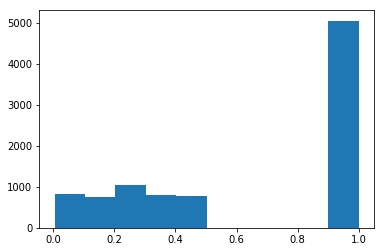

In [39]:
plt.hist(np.max(p, 1))

In [37]:
p[1]

array([0.        , 0.        , 0.47866667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [40]:
np.mean(np.argmax(p, 1) == y_test)

0.9883243243243244

In [41]:
pickle.dump(alphas, open("alphas_test.p", "wb"))

---

## 1. Attack Baseline (from paper)

In [17]:
X_3 = X_train[y_train == 3]
X_7 = X_train[y_train == 7]
X_37 = X_train[(y_train == 3) | (y_train == 7)]
y_37 = y_train[(y_train == 3) | (y_train == 7)]
X_37_test = X_test[(y_test == 3) | (y_test == 7)]
y_37_test = y_test[(y_test == 3) | (y_test == 7)]

In [18]:
rep_37_test = [rep[(y_test == 3) | (y_test == 7)] for rep in rep_test_nm]

In [321]:
class BaselineAttack(object):
    
    def __init__(self, sess, model, get_rep, X, X_rep, y_X, 
                 pert_norm=2, batch_size=1000, lr=1e-3, 
                 abort_early=True, init_const=1, min_dist=1,
                 pert_bound=0.3):
        """
        X_rep must be normalized
        """
    
        self.sess = sess
        self.model = model
        self.X = X
        self.X_rep = X_rep
        self.y_X = y_X
        self.batch_size = batch_size
        self.abort_early = abort_early
        self.init_const = init_const
        self.min_dist = min_dist
        self.pert_norm = pert_norm
        self.pert_bound = pert_bound
        
        input_ndim = X.ndim
        input_axis = np.arange(1, input_ndim)
        input_shape = (batch_size, ) + X.shape[1:]
        rep_ndim = X_rep.ndim
        rep_axis = np.arange(1, rep_ndim)
        rep_shape = (batch_size, ) + X_rep.shape[1:]

        # Objective variable
        modifier = tf.Variable(np.zeros(input_shape), dtype=tf.float32)

        # These are variables to be more efficient in sending data to tf
        q_var = tf.Variable(np.zeros(input_shape), dtype=tf.float32, name='q_var')
        target_var = tf.Variable(np.zeros(rep_shape), dtype=tf.float32, name='target_var')
        const_var = tf.Variable(
            np.zeros(batch_size), dtype=tf.float32, name='const_var')

        # and here's what we use to assign them
        self.assign_q = tf.placeholder(tf.float32, input_shape, name='assign_q')
        self.assign_target = tf.placeholder(tf.float32, rep_shape, name='assign_target')
        self.assign_const = tf.placeholder(
            tf.float32, [batch_size], name='assign_const')

        # Clip to ensure pixel value is between 0 and 1
        self.new_q = tf.clip_by_value(q_var + modifier, 0., 1.)
        # Get reprentation tensor
        rep = get_rep(self.new_q)
        rep = tf.reshape(rep, [batch_size, -1])
        self.rep = rep / tf.norm(rep, axis=1, keepdims=True)

        # L2 perturbation loss
        l2dist = tf.reduce_sum(tf.square(modifier), input_axis)
        self.l2dist = tf.maximum(0., l2dist - self.pert_bound**2)
        # Similarity loss
        dist_loss = tf.reduce_sum(tf.square(self.rep - target_var), rep_axis)
        self.dist_loss = tf.maximum(0., dist_loss - self.min_dist**2)
        
        # Setup optimizer
        start_vars = set(x.name for x in tf.global_variables())
        if pert_norm == 2:
            # For L-2 norm constraint, we use Adam optimizer with
            # a penalty term
            self.loss = tf.reduce_mean(const_var*self.dist_loss + self.l2dist)
            optimizer = tf.train.AdamOptimizer(lr)
            self.train_step = optimizer.minimize(self.loss, var_list=[modifier])
        elif pert_norm == np.inf:
            # For L-inf norm constraint, we use L-BFGS-B optimizer 
            # to provide correct bound, optimizer setup is moved to attack()
            self.loss = tf.reduce_mean(self.dist_loss)
            self.modifier = modifier
        else:
            raise ValueError('Invalid choice for perturbation norm!')
            
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        self.setup = []
        self.setup.append(q_var.assign(self.assign_q))
        self.setup.append(target_var.assign(self.assign_target))
        self.setup.append(const_var.assign(self.assign_const))
        self.init = tf.variables_initializer(var_list=[modifier] + new_vars)
        
    def attack(self, Q, Q_rep, y_Q, bin_search_steps=5, max_iter=200):
        r = []
        for i in range(0, len(Q), self.batch_size):
            print("Running Baseline Attack on instance {} of {}".format(
                i, len(Q)))
            r.extend(self.attack_batch(Q[i:i + self.batch_size],
                                       Q_rep[i:i + self.batch_size],
                                       y_Q[i:i + self.batch_size],
                                       bin_search_steps=bin_search_steps,
                                       max_iter=max_iter))
        return np.array(r)

        
    def attack_batch(self, Q, Q_rep, y_Q, bin_search_steps=5, max_iter=200):   
        
        # Find closest rep of different class
        print("  Finding nn representation as target...")
        nn = find_nn_diff_class(Q_rep, y_Q, self.X_rep, self.y_X, 1)
        target_rep = np.squeeze(self.X_rep[nn])
        # Find nn to target rep to save nn search time during optimization
        # check_rep = find_nn(target_rep, self.X_rep, 100)
        
        # ============ Optimizing with L-inf norm constraints =========== #
        # L-BFGS-B optimizer only needs to be called once
        if self.pert_norm == np.inf:
            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            target_rep_batch = target_rep[:self.batch_size]
            const = np.ones(self.batch_size) * self.init_const
            
            # Set the variables so that we don't have to send them over again
            self.sess.run(
                self.setup, {
                    self.assign_q: Q_batch,
                    self.assign_target: target_rep_batch,
                    self.assign_const: const
                })
            
            # Set up variables bound and optimizer
            upper_bound = np.minimum(self.pert_bound, 1 - Q_batch)
            lower_bound = np.maximum(-self.pert_bound, -Q_batch)
            var_to_bounds = {self.modifier: (lower_bound, upper_bound)}
            optimizer = tf.contrib.opt.ScipyOptimizerInterface(
                self.loss, 
                var_list=[self.modifier], 
                var_to_bounds=var_to_bounds, 
                method='L-BFGS-B')
            
            # Call optimizer
            optimizer.minimize(self.sess)
            return self.sess.run(self.new_q)
            
        # ============= Optimizing with L2 norm constraints ============ #
        o_bestl2 = [1e9] * self.batch_size
        o_bestadv = np.zeros_like(Q[:self.batch_size])
        
        # Set the lower and upper bounds
        lower_bound = np.zeros(self.batch_size)
        const = np.ones(self.batch_size) * self.init_const
        upper_bound = np.ones(self.batch_size) * 1e9
       
        for outer_step in range(bin_search_steps):

            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            target_rep_batch = target_rep[:self.batch_size]
            
            bestl2 = [1e9] * self.batch_size
            bestadv = np.zeros_like(Q_batch)
            print("  Binary search step {} of {}".format(
                outer_step, bin_search_steps))

            # Set the variables so that we don't have to send them over again
            self.sess.run(
                self.setup, {
                    self.assign_q: Q_batch,
                    self.assign_target: target_rep_batch,
                    self.assign_const: const
                })

            prev = 1e6
            for iteration in range(max_iter):
                # Take one step in optimization
                _, l, l2s, dls, reps, qs = self.sess.run([self.train_step, 
                                                          self.loss, 
                                                          self.l2dist,
                                                          self.dist_loss,
                                                          self.rep, 
                                                          self.new_q])
                
                if iteration % ((max_iter // 10) or 1) == 0:
                    print(("    Iteration {} of {}: loss={:.3g} l2={:.3g}").format(
                        iteration, max_iter, l, np.mean(l2s)))
                
                # Abort early if stop improving
                if self.abort_early and iteration % ((max_iter // 10) or 1) == 0:
                    if l > prev * .9999:
                        print("    Failed to make progress; stop early")
                        break
                    prev = l
                
                # Check termination condition
                suc_ind = np.where(dls <= 1e-1)[0]
                for ind in suc_ind:
                    if l2s[ind] < bestl2[ind]:
                        bestl2[ind] = l2s[ind]
                        bestadv[ind] = qs[ind]

                        
            # Adjust const according to results
            for e in range(self.batch_size):
                if bestl2[e] < 1e9:
                    # Success, divide const by two
                    upper_bound[e] = min(upper_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    if bestl2[e] < o_bestl2[e]:
                        o_bestl2[e] = bestl2[e]
                        o_bestadv[e] = bestadv[e]
                else:
                    # Failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    else:
                        const[e] *= 10
                        
        return o_bestadv

In [364]:
baseline = BaselineAttack(sess, model, l1_rep, 
                          X_train, rep_train_nm[0], y_train, 
                          pert_norm=np.inf,
                          batch_size=5, 
                          min_dist=0.1,
                          pert_bound=0.3)

In [365]:
X_adv = baseline.attack(X_37_test[:5], rep_37_test[0][:5], y_37_test[:5])

Running Baseline Attack on instance 0 of 5
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.169774
  Number of iterations: 56
  Number of functions evaluations: 57


In [322]:
baseline = BaselineAttack(sess, model, l1_rep, 
                          X_train, rep_train_nm[0], y_train, 
                          pert_norm=2,
                          batch_size=5, 
                          lr=1e-2, 
                          abort_early=True,
                          init_const=1, 
                          min_dist=0.1,
                          pert_bound=0)

In [323]:
X_adv = baseline.attack(X_37_test[:5], rep_37_test[0][:5], y_37_test[:5],
                        bin_search_steps=5, max_iter=500)

Running Baseline Attack on instance 0 of 5
  Finding nn representation as target...
  Binary search step 0 of 5
    Iteration 0 of 500: loss=0.625 l2=0
    Iteration 50 of 500: loss=0.616 l2=0.00928
    Iteration 100 of 500: loss=0.616 l2=0.0093
    Failed to make progress; stop early
  Binary search step 1 of 5
    Iteration 0 of 500: loss=6.25 l2=0
    Iteration 50 of 500: loss=5.43 l2=0.747
    Iteration 100 of 500: loss=5.43 l2=0.754
    Iteration 150 of 500: loss=5.43 l2=0.754
    Failed to make progress; stop early
  Binary search step 2 of 5
    Iteration 0 of 500: loss=62.5 l2=0
    Iteration 50 of 500: loss=24.1 l2=12.6
    Iteration 100 of 500: loss=22 l2=15.2
    Iteration 150 of 500: loss=22 l2=15.2
    Iteration 200 of 500: loss=22 l2=15.2
    Failed to make progress; stop early
  Binary search step 3 of 5
    Iteration 0 of 500: loss=270 l2=0
    Iteration 50 of 500: loss=70.4 l2=14.1
    Iteration 100 of 500: loss=28.2 l2=20.8
    Iteration 150 of 500: loss=24.1 l2=20.8


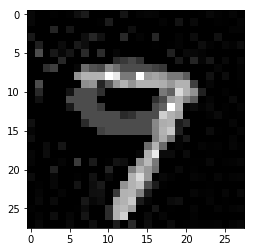

In [366]:
plt.imshow(X_adv[0,:,:,0], cmap='gray')

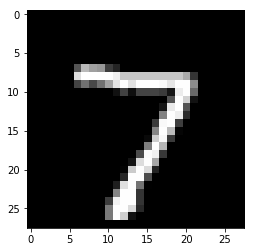

In [367]:
plt.imshow(X_37_test[0,:,:,0], cmap='gray')

In [368]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test[:5], query, y_train)

In [369]:
acc

0.8

In [370]:
np.argmax(p, 1)

array([7, 7, 5, 7, 3])

In [371]:
np.sqrt(np.sum((X_adv - X_37_test[:5])**2, (1,2,3)))

array([3.56837978, 3.73891273, 3.92854395, 3.50711337, 3.50198879])

In [330]:
np.sqrt(np.sum(get_all_rep_nm(X_adv)[0]**2, 1))

array([1., 1., 1., 1., 1.])

In [338]:
baseline = BaselineAttack(sess, model, l1_rep, 
                          X_train, rep_train_nm[0], y_train, 
                          pert_norm=np.inf,
                          batch_size=32,
                          min_dist=0.1,
                          pert_bound=0.3)

In [339]:
X_adv = baseline.attack(X_37_test, rep_37_test[0], y_37_test)

Running Baseline Attack on instance 0 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.176595
  Number of iterations: 48
  Number of functions evaluations: 49
Running Baseline Attack on instance 32 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.149688
  Number of iterations: 44
  Number of functions evaluations: 45
Running Baseline Attack on instance 64 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.147744
  Number of iterations: 44
  Number of functions evaluations: 45
Running Baseline Attack on instance 96 of 1888
  Finding nn representation as target...
INFO:tensorflow:

Running Baseline Attack on instance 896 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.168110
  Number of iterations: 49
  Number of functions evaluations: 50
Running Baseline Attack on instance 928 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.148064
  Number of iterations: 50
  Number of functions evaluations: 51
Running Baseline Attack on instance 960 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.150963
  Number of iterations: 43
  Number of functions evaluations: 44
Running Baseline Attack on instance 992 of 1888
  Finding nn representation as target...
INFO:tensor

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.174235
  Number of iterations: 61
  Number of functions evaluations: 62
Running Baseline Attack on instance 1792 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.139979
  Number of iterations: 39
  Number of functions evaluations: 40
Running Baseline Attack on instance 1824 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.135444
  Number of iterations: 33
  Number of functions evaluations: 34
Running Baseline Attack on instance 1856 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIEN

In [340]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test, query, y_train)
print(acc)
print(np.argmax(p, 1))

0.6091101694915254
[7 7 5 ... 3 7 3]


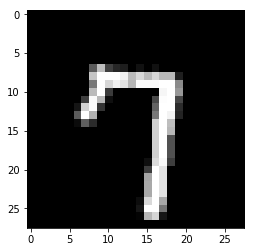

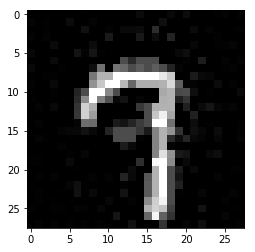

9


In [354]:
i = 19
plt.imshow(X_37_test[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()
print(np.argmax(p, 1)[i])

---

## 2. Slightly improved baseline

In [19]:
def find_nn_diff_class_l2(Q, y_Q, X, y_X, k):
    target = np.zeros((len(Q), k), dtype=np.int32)
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    for i, (q, y_q) in enumerate(zip(Q, y_Q)):
        ind = np.argsort(np.sum((X - q)**2, axis=axis))
        target[i] = ind[y_X[ind] != y_q][:k]
    return target

In [356]:
class AttackV2(object):
    
    def __init__(self, sess, model, get_rep, X, X_rep, y_X, 
                 pert_norm=2, batch_size=1000, lr=1e-3, 
                 abort_early=True, init_const=1, min_dist=1,
                 pert_bound=0.3):
        """
        X_rep must be normalized
        """
    
        self.sess = sess
        self.model = model
        self.X = X
        self.X_rep = X_rep
        self.y_X = y_X
        self.batch_size = batch_size
        self.abort_early = abort_early
        self.init_const = init_const
        self.min_dist = min_dist
        self.pert_norm = pert_norm
        self.pert_bound = pert_bound
        
        input_ndim = X.ndim
        input_axis = np.arange(1, input_ndim)
        input_shape = (batch_size, ) + X.shape[1:]
        rep_ndim = X_rep.ndim
        rep_axis = np.arange(1, rep_ndim)
        rep_shape = (batch_size, ) + X_rep.shape[1:]

        # Objective variable
        modifier = tf.Variable(np.zeros(input_shape), dtype=tf.float32)

        # These are variables to be more efficient in sending data to tf
        q_var = tf.Variable(np.zeros(input_shape), dtype=tf.float32, name='q_var')
        target_var = tf.Variable(np.zeros(rep_shape), dtype=tf.float32, name='target_var')
        const_var = tf.Variable(
            np.zeros(batch_size), dtype=tf.float32, name='const_var')

        # and here's what we use to assign them
        self.assign_q = tf.placeholder(tf.float32, input_shape, name='assign_q')
        self.assign_target = tf.placeholder(tf.float32, rep_shape, name='assign_target')
        self.assign_const = tf.placeholder(
            tf.float32, [batch_size], name='assign_const')

        # Clip to ensure pixel value is between 0 and 1
        self.new_q = tf.clip_by_value(q_var + modifier, 0., 1.)
        # Get reprentation tensor
        rep = get_rep(self.new_q)
        rep = tf.reshape(rep, [batch_size, -1])
        self.rep = rep / tf.norm(rep, axis=1, keepdims=True)

        # L2 perturbation loss
        l2dist = tf.reduce_sum(tf.square(modifier), input_axis)
        self.l2dist = tf.maximum(0., l2dist - self.pert_bound**2)
        # Similarity loss
        dist_loss = tf.reduce_sum(tf.square(self.rep - target_var), rep_axis)
        self.dist_loss = tf.maximum(0., dist_loss - self.min_dist**2)
        
        # Setup optimizer
        start_vars = set(x.name for x in tf.global_variables())
        if pert_norm == 2:
            # For L-2 norm constraint, we use Adam optimizer with
            # a penalty term
            self.loss = tf.reduce_mean(const_var*self.dist_loss + self.l2dist)
            optimizer = tf.train.AdamOptimizer(lr)
            self.train_step = optimizer.minimize(self.loss, var_list=[modifier])
        elif pert_norm == np.inf:
            # For L-inf norm constraint, we use L-BFGS-B optimizer 
            # to provide correct bound, optimizer setup is moved to attack()
            self.loss = tf.reduce_mean(self.dist_loss)
            self.modifier = modifier
        else:
            raise ValueError('Invalid choice for perturbation norm!')
            
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        self.setup = []
        self.setup.append(q_var.assign(self.assign_q))
        self.setup.append(target_var.assign(self.assign_target))
        self.setup.append(const_var.assign(self.assign_const))
        self.init = tf.variables_initializer(var_list=[modifier] + new_vars)
        
    def attack(self, Q, Q_rep, y_Q, bin_search_steps=5, max_iter=200):
        r = []
        for i in range(0, len(Q), self.batch_size):
            print("Running Baseline Attack on instance {} of {}".format(
                i, len(Q)))
            r.extend(self.attack_batch(Q[i:i + self.batch_size],
                                       Q_rep[i:i + self.batch_size],
                                       y_Q[i:i + self.batch_size],
                                       bin_search_steps=bin_search_steps,
                                       max_iter=max_iter))
        return np.array(r)

        
    def attack_batch(self, Q, Q_rep, y_Q, bin_search_steps=5, max_iter=200):   
        
        # Find closest rep of different class
        print("  Finding nn representation as target...")
        
#         nn = find_nn_diff_class(Q_rep, y_Q, self.X_rep, self.y_X, 1)
        nn = find_nn_diff_class_l2(Q, y_Q, self.X, self.y_X, 1)

        target_rep = np.squeeze(self.X_rep[nn])
        # Find nn to target rep to save nn search time during optimization
        # check_rep = find_nn(target_rep, self.X_rep, 100)
        
        # ============ Optimizing with L-inf norm constraints =========== #
        # L-BFGS-B optimizer only needs to be called once
        if self.pert_norm == np.inf:
            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            target_rep_batch = target_rep[:self.batch_size]
            const = np.ones(self.batch_size) * self.init_const
            
            # Set the variables so that we don't have to send them over again
            self.sess.run(
                self.setup, {
                    self.assign_q: Q_batch,
                    self.assign_target: target_rep_batch,
                    self.assign_const: const
                })
            
            # Set up variables bound and optimizer
            upper_bound = np.minimum(self.pert_bound, 1 - Q_batch)
            lower_bound = np.maximum(-self.pert_bound, -Q_batch)
            var_to_bounds = {self.modifier: (lower_bound, upper_bound)}
            optimizer = tf.contrib.opt.ScipyOptimizerInterface(
                self.loss, 
                var_list=[self.modifier], 
                var_to_bounds=var_to_bounds, 
                method='L-BFGS-B')
            
            # Call optimizer
            optimizer.minimize(self.sess)
            return self.sess.run(self.new_q)
            
        # ============= Optimizing with L2 norm constraints ============ #
        o_bestl2 = [1e9] * self.batch_size
        o_bestadv = np.zeros_like(Q[:self.batch_size])
        
        # Set the lower and upper bounds
        lower_bound = np.zeros(self.batch_size)
        const = np.ones(self.batch_size) * self.init_const
        upper_bound = np.ones(self.batch_size) * 1e9
       
        for outer_step in range(bin_search_steps):

            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            target_rep_batch = target_rep[:self.batch_size]
            
            bestl2 = [1e9] * self.batch_size
            bestadv = np.zeros_like(Q_batch)
            print("  Binary search step {} of {}".format(
                outer_step, bin_search_steps))

            # Set the variables so that we don't have to send them over again
            self.sess.run(
                self.setup, {
                    self.assign_q: Q_batch,
                    self.assign_target: target_rep_batch,
                    self.assign_const: const
                })

            prev = 1e6
            for iteration in range(max_iter):
                # Take one step in optimization
                _, l, l2s, dls, reps, qs = self.sess.run([self.train_step, 
                                                          self.loss, 
                                                          self.l2dist,
                                                          self.dist_loss,
                                                          self.rep, 
                                                          self.new_q])
                
                if iteration % ((max_iter // 10) or 1) == 0:
                    print(("    Iteration {} of {}: loss={:.3g} l2={:.3g}").format(
                        iteration, max_iter, l, np.mean(l2s)))
                
                # Abort early if stop improving
                if self.abort_early and iteration % ((max_iter // 10) or 1) == 0:
                    if l > prev * .9999:
                        print("    Failed to make progress; stop early")
                        break
                    prev = l
                
                # Check termination condition
                # nn = find_nn(reps, self.X_rep, 1)
                # y_pred = classify(nn, self.y_X)
                # suc_ind = np.where(y_pred != y_Q)[0]
                suc_ind = np.where(dls <= 1e-1)[0]
                for ind in suc_ind:
                    if l2s[ind] < bestl2[ind]:
                        bestl2[ind] = l2s[ind]
                        bestadv[ind] = qs[ind]

                        
            # Adjust const according to results
            for e in range(self.batch_size):
                if bestl2[e] < 1e9:
                    # Success, divide const by two
                    upper_bound[e] = min(upper_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    if bestl2[e] < o_bestl2[e]:
                        o_bestl2[e] = bestl2[e]
                        o_bestadv[e] = bestadv[e]
                else:
                    # Failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    else:
                        const[e] *= 10
                        
        return o_bestadv

In [377]:
attack = AttackV2(sess, model, l1_rep, 
                  X_train, rep_train_nm[0], y_train, 
                  pert_norm=np.inf,
                  batch_size=5, 
                  min_dist=0,
                  pert_bound=0.3)

In [378]:
X_adv = attack.attack(X_37_test[:5], rep_37_test[0][:5], y_37_test[:5])

Running Baseline Attack on instance 0 of 5
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.200503
  Number of iterations: 61
  Number of functions evaluations: 62


In [379]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test[:5], query, y_train)
print(acc)
print(np.argmax(p, 1))

0.8
[7 7 3 9 3]


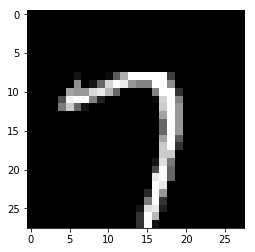

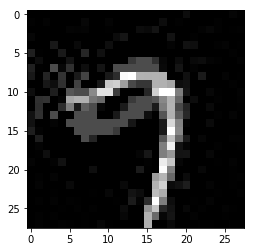

In [381]:
i = 3
plt.imshow(X_37_test[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()

In [382]:
np.sqrt(np.sum((X_adv - X_37_test[:5])**2, (1,2,3)))

array([3.6045725 , 3.89791851, 3.98171894, 3.10472688, 3.74187468])

In [384]:
attack = AttackV2(sess, model, l1_rep, 
                  X_train, rep_train_nm[0], y_train, 
                  pert_norm=np.inf,
                  batch_size=32,
                  min_dist=0.,
                  pert_bound=0.3)

In [386]:
X_adv = attack.attack(X_37_test, rep_37_test[0], y_37_test)

Running Baseline Attack on instance 0 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.200702
  Number of iterations: 44
  Number of functions evaluations: 45
Running Baseline Attack on instance 32 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.185852
  Number of iterations: 51
  Number of functions evaluations: 52
Running Baseline Attack on instance 64 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.188620
  Number of iterations: 46
  Number of functions evaluations: 47
Running Baseline Attack on instance 96 of 1888
  Finding nn representation as target...
INFO:tensorflow:

Running Baseline Attack on instance 896 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.200670
  Number of iterations: 51
  Number of functions evaluations: 52
Running Baseline Attack on instance 928 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.180258
  Number of iterations: 39
  Number of functions evaluations: 40
Running Baseline Attack on instance 960 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.177439
  Number of iterations: 44
  Number of functions evaluations: 45
Running Baseline Attack on instance 992 of 1888
  Finding nn representation as target...
INFO:tensor

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.202580
  Number of iterations: 54
  Number of functions evaluations: 55
Running Baseline Attack on instance 1792 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.179952
  Number of iterations: 40
  Number of functions evaluations: 41
Running Baseline Attack on instance 1824 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.167998
  Number of iterations: 39
  Number of functions evaluations: 40
Running Baseline Attack on instance 1856 of 1888
  Finding nn representation as target...
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIEN

In [387]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test, query, y_train)
print(acc)
print(np.argmax(p, 1))

0.6350635593220338
[7 7 3 ... 3 7 3]


---
## 3. AttackV3

In [20]:
def find_nn_l2(Q, X, k):
    assert Q.shape[1:] == X.shape[1:]
    nn = np.zeros((len(Q), k), dtype=np.int32)
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    for i, q in enumerate(Q):
        ind = np.argsort(np.sum((X - q)**2, axis=axis))[:k]
        nn[i] = ind
    return nn

In [22]:
class AttackV3(object):
    
    def __init__(self, sess, model, get_rep, X, X_rep, y_X, 
                 pert_norm=np.inf, batch_size=1000, lr=1e-3, 
                 abort_early=True, init_const=1, pert_bound=0.3,
                 min_dist=None, m=100, target_nn=38):
        """
        X_rep must be normalized and flattened
        m: (int) number of neighbors to consider
        """
    
        self.sess = sess
        self.model = model
        self.X = X
        self.X_rep = X_rep
        self.y_X = y_X
        self.n_layers = len(X_rep)
        self.batch_size = batch_size
        self.abort_early = abort_early
        self.init_const = init_const
        self.pert_norm = pert_norm
        self.pert_bound = pert_bound
        if min_dist is None:
            min_dist = [0.1]*self.n_layers
        self.min_dist = min_dist
        self.m = m
        self.target_nn = target_nn
        
        assert self.n_layers == len(get_rep)
        
        input_ndim = X.ndim
        input_axis = np.arange(1, input_ndim)
        input_shape = (batch_size, ) + X.shape[1:]

        
        # =============== Set up variables and placeholders =============== #
        # Objective variable
        modifier = tf.Variable(np.zeros(input_shape), dtype=tf.float32)

        # These are variables to be more efficient in sending data to tf
        q_var = tf.Variable(np.zeros(input_shape), dtype=tf.float32, name='q_var')
        x_var = []
        for l in range(self.n_layers):
            rep_shape = (batch_size, m, X_rep[l].shape[1])
            x_var.append(tf.Variable(np.zeros(rep_shape), 
                                     dtype=tf.float32, 
                                     name='x_var_{}'.format(l)))
        w_var = tf.Variable(np.zeros((batch_size, m, 1)), 
                            dtype=tf.float32, 
                            name='w_var_{}'.format(l))
        const_var = tf.Variable(
            np.zeros(batch_size), dtype=tf.float32, name='const_var')
        steep_var = tf.Variable(
            np.zeros((batch_size, 1, 1)), dtype=tf.float32, name='const_var')

        # and here's what we use to assign them
        self.assign_q = tf.placeholder(tf.float32, input_shape, name='assign_q')
        self.assign_x = []
        for l in range(self.n_layers):
            rep_shape = (batch_size, m, X_rep[l].shape[1])
            self.assign_x.append(tf.placeholder(tf.float32, 
                                                rep_shape, 
                                                name='assign_x_{}'.format(l)))
        self.assign_w = tf.placeholder(tf.float32, 
                                       [batch_size, m, 1], 
                                       name='assign_w_{}'.format(l))
        self.assign_const = tf.placeholder(
            tf.float32, [batch_size], name='assign_const')
        self.assign_steep = tf.placeholder(
            tf.float32, [batch_size, 1, 1], name='assign_steep')

        
        # ================= Get reprentation tensor ================= #
        # Clip to ensure pixel value is between 0 and 1
        self.new_q = tf.clip_by_value(q_var + modifier, 0., 1.)
        self.rep = []
        for l in range(self.n_layers):
            rep = get_rep[l](self.new_q)
            rep = tf.reshape(rep, [batch_size, 1, -1])
            rep = rep / tf.norm(rep, axis=2, keepdims=True)
            self.rep.append(rep)

        # L2 perturbation loss
        l2dist = tf.reduce_sum(tf.square(modifier), input_axis)
        self.l2dist = tf.maximum(0., l2dist - self.pert_bound**2)
        
        
        # ================== Approximate NN loss ================== #
        def sigmoid(x, a=1):
            return 1/(1 + tf.exp(-a*x))
        
        self.nn_loss = 0
        for l in range(self.n_layers):
            dist = tf.norm(self.rep[l] - x_var[l], axis=2, keepdims=True)
            self.nn_loss += tf.reduce_sum(
                w_var * sigmoid(min_dist[l] - dist, steep_var), (1, 2))
        
        
        # ==================== Setup optimizer ==================== #
        start_vars = set(x.name for x in tf.global_variables())
        if pert_norm == 2:
            # For L-2 norm constraint, we use Adam optimizer with
            # a penalty term
            self.loss = tf.reduce_mean(const_var*self.nn_loss + self.l2dist)
            optimizer = tf.train.AdamOptimizer(lr)
            self.train_step = optimizer.minimize(self.loss, var_list=[modifier])
        elif pert_norm == np.inf:
            # For L-inf norm constraint, we use L-BFGS-B optimizer 
            # to provide correct bound, optimizer setup is moved to attack()
            self.loss = tf.reduce_mean(self.nn_loss)
            self.modifier = modifier
        else:
            raise ValueError('Invalid choice for perturbation norm!')
            
            
        # DEBUG
        self.dist = dist
        self.rep_db = rep
        self.gradient = tf.gradients(self.nn_loss, modifier)
        print('rep: ', self.rep)
        # dist: (batch_size, m, 1)
        print('dist: ', dist)
        # sigmoid: (batch_size, m, 1)
        print('sigmoid: ', sigmoid(min_dist[l] - dist, steep_var))
        # weights: (batch_size, m, 1)
        print('weights: ', w_var * sigmoid(min_dist[l] - dist, steep_var))
        # loss, nn_loss: (batch_size, )
        print('loss: ', tf.reduce_sum(
            w_var * sigmoid(min_dist[l] - dist, steep_var), (1, 2)))
        print('nn_loss: ', self.nn_loss)
        
            
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        self.setup = []
        self.setup.append(q_var.assign(self.assign_q))
        self.setup.extend([x_var[l].assign(self.assign_x[l]) 
                           for l in range(self.n_layers)])
        self.setup.append(w_var.assign(self.assign_w))
        self.setup.append(steep_var.assign(self.assign_steep))
        self.setup.append(const_var.assign(self.assign_const))
        self.init = tf.variables_initializer(var_list=[modifier] + new_vars)
        
    def attack(self, Q, y_Q, bin_search_steps=5, max_iter=200):
        r = []
        for i in range(0, len(Q), self.batch_size):
            print("Running Baseline Attack on instance {} of {}".format(
                i, len(Q)))
            r.extend(self.attack_batch(Q[i:i + self.batch_size],
                                       y_Q[i:i + self.batch_size],
                                       bin_search_steps=bin_search_steps,
                                       max_iter=max_iter))
        return np.array(r)

        
    def attack_batch(self, Q, y_Q, bin_search_steps=5, max_iter=200):   
        
        # Find closest rep of different class
        print("  Finding nn representation as target...")
        
        # TODO: 
        # nn = find_nn_diff_class_l2(Q, y_Q, self.X, self.y_X, self.m)
        nn = find_nn_l2(Q, self.X, self.m)
        rep_m = [np.squeeze(rep[nn]) for rep in self.X_rep]
        
        # Get weights w
        w = 2*(self.y_X[nn] == y_Q[:, np.newaxis]).astype(np.float32) - 1
        print(np.mean(w == -1, axis=1))
        
        # Initialize steep
        steep = np.ones((self.batch_size, 1, 1))
        
        # Find nn to target rep to save nn search time during optimization
        # check_rep = find_nn(target_rep, self.X_rep, 100)
        
        # ============ Optimizing with L-inf norm constraints =========== #
        # L-BFGS-B optimizer only needs to be called once
        if self.pert_norm == np.inf:
            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            const = np.ones(self.batch_size) * self.init_const
            
            # Set the variables so that we don't have to send them over again
            setup_dict = {self.assign_q: Q_batch,
                          self.assign_w: w[:, :, np.newaxis],
                          self.assign_const: const,
                          self.assign_steep: steep}
            for l in range(self.n_layers):
                setup_dict[self.assign_x[l]] = rep_m[l]
            self.sess.run(self.setup, feed_dict=setup_dict)
            
            # Set up variables bound and optimizer
            upper_bound = np.minimum(self.pert_bound, 1 - Q_batch)
            lower_bound = np.maximum(-self.pert_bound, -Q_batch)
            var_to_bounds = {self.modifier: (lower_bound, upper_bound)}
            optimizer = tf.contrib.opt.ScipyOptimizerInterface(
                self.loss, 
                var_list=[self.modifier], 
                var_to_bounds=var_to_bounds, 
                method='L-BFGS-B')
            
            # Call optimizer
            optimizer.minimize(self.sess)
            return self.sess.run(self.new_q)
            
        # ============= Optimizing with L2 norm constraints ============ #
        o_bestl2 = [1e9] * self.batch_size
        o_bestadv = np.zeros_like(Q[:self.batch_size])
        
        # Set the lower and upper bounds
        lower_bound = np.zeros(self.batch_size)
        const = np.ones(self.batch_size) * self.init_const
        upper_bound = np.ones(self.batch_size) * 1e9
       
        for outer_step in range(bin_search_steps):

            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            
            bestl2 = [1e9] * self.batch_size
            bestadv = np.zeros_like(Q_batch)
            print("  Binary search step {} of {}".format(
                outer_step, bin_search_steps))

            # Set the variables so that we don't have to send them over again
            setup_dict = {self.assign_q: Q_batch,
                          self.assign_w: w[:, :, np.newaxis],
                          self.assign_const: const,
                          self.assign_steep: steep}
            for l in range(self.n_layers):
                setup_dict[self.assign_x[l]] = rep_m[l]
            self.sess.run(self.setup, feed_dict=setup_dict)

            prev = 1e6
            for iteration in range(max_iter):
                # Take one step in optimization
                _, l, l2s, dls, reps, qs = self.sess.run([self.train_step, 
                                                          self.loss, 
                                                          self.l2dist,
                                                          self.nn_loss,
                                                          self.rep, 
                                                          self.new_q])
                # DEBUG
#                 print(self.sess.run(self.dist))
#                 grad = self.sess.run(self.gradient)
#                 print(grad)
#                 rep = self.sess.run(self.rep_db)
#                 print(rep.shape)
#                 print(np.sum(rep**2, axis=2))
                
                if iteration % ((max_iter // 10) or 1) == 0:
                    print(("    Iteration {} of {}: loss={:.3g} l2={:.3g}").format(
                        iteration, max_iter, l, np.mean(l2s)))
                
                # Abort early if stop improving
                if self.abort_early and iteration % ((max_iter // 10) or 1) == 0:
                    if l > prev * .9999:
                        print("    Failed to make progress; stop early")
                        break
                    prev = l
                
                # Check termination condition
                # nn = find_nn(reps, self.X_rep, 1)
                # y_pred = classify(nn, self.y_X)
                # suc_ind = np.where(y_pred != y_Q)[0]
                # suc_ind = np.where(dls <= 1e-1)[0]
                if (iteration + 1) % 10 == 0:
                    p, _ = dknn_acc(A, get_all_rep_nm(qs), y_Q, query, self.y_X)
                    suc_ind = np.where(np.argmax(p, 1) != y_Q)[0]
                    for ind in suc_ind:
                        if l2s[ind] < bestl2[ind]:
                            bestl2[ind] = l2s[ind]
                            bestadv[ind] = qs[ind]
                        
            # Adjust const according to results
            for e in range(self.batch_size):
                if bestl2[e] < 1e9:
                    # Success, divide const by two
                    upper_bound[e] = min(upper_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    if bestl2[e] < o_bestl2[e]:
                        o_bestl2[e] = bestl2[e]
                        o_bestadv[e] = bestadv[e]
                else:
                    # Failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    else:
                        const[e] *= 10
                        
        return o_bestadv

In [540]:
# Try to approximate min_dist (epsilon) by calculating average distance 
# between queries and their 75th NN
min_dist = []
for l in range(4):
#     nn = find_nn_l2(rep_test_nm[l], rep_train_nm[l], 75)
    nn = query_nn(query[l], rep_test_nm[l], 75)
    dist = np.sqrt(np.sum((rep_test_nm[l] - rep_train_nm[l][nn[:, -1]])**2, axis=1))
    min_dist.append(np.mean(dist))

In [24]:
min_dist = [0.7484518915597577, 0.742514077896593, 0.5667317128548899, 0.19457440222463473]

In [543]:
attack = AttackV3(sess, model, 
                  [l1_rep, l2_rep, l3_rep, l4_rep], 
                  X_train, rep_train_nm, y_train, 
                  pert_norm=np.inf,
                  batch_size=5, 
                  min_dist=min_dist,
                  pert_bound=0.3,
                  m=500, 
                  target_nn=38)

rep:  [<tf.Tensor 'truediv_470:0' shape=(5, 1, 12544) dtype=float32>, <tf.Tensor 'truediv_471:0' shape=(5, 1, 6272) dtype=float32>, <tf.Tensor 'truediv_472:0' shape=(5, 1, 1152) dtype=float32>, <tf.Tensor 'truediv_473:0' shape=(5, 1, 10) dtype=float32>]
dist:  Tensor("norm_327/Sqrt:0", shape=(5, 500, 1), dtype=float32)
sigmoid:  Tensor("truediv_478:0", shape=(5, 500, 1), dtype=float32)
weights:  Tensor("mul_549:0", shape=(5, 500, 1), dtype=float32)
loss:  Tensor("Sum_348:0", shape=(5,), dtype=float32)
nn_loss:  Tensor("add_558:0", shape=(5,), dtype=float32)


In [544]:
X_adv = attack.attack(X_37_test[:5], y_37_test[:5])

Running Baseline Attack on instance 0 of 5
  Finding nn representation as target...
[0.002 0.006 0.35  0.144 0.078]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 453.059662
  Number of iterations: 2081
  Number of functions evaluations: 2106


In [545]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test[:5], query, y_train)
print(acc)
print(np.argmax(p, 1))

0.0
[6 6 6 0 0]


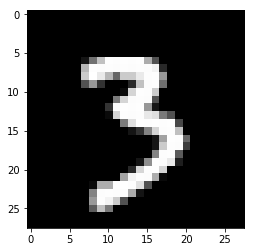

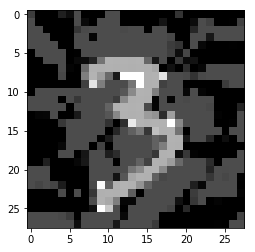

In [550]:
i = 4
plt.imshow(X_37_test[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()

In [558]:
attack = AttackV3(sess, model, 
                  [l1_rep, l2_rep, l3_rep, l4_rep], 
                  X_train, rep_train_nm, y_train, 
                  pert_norm=2,
                  batch_size=5, 
                  min_dist=min_dist,
                  pert_bound=0,
                  m=500, 
                  target_nn=38)

rep:  [<tf.Tensor 'truediv_481:0' shape=(5, 1, 12544) dtype=float32>, <tf.Tensor 'truediv_482:0' shape=(5, 1, 6272) dtype=float32>, <tf.Tensor 'truediv_483:0' shape=(5, 1, 1152) dtype=float32>, <tf.Tensor 'truediv_484:0' shape=(5, 1, 10) dtype=float32>]
dist:  Tensor("norm_335/Sqrt:0", shape=(5, 500, 1), dtype=float32)
sigmoid:  Tensor("truediv_489:0", shape=(5, 500, 1), dtype=float32)
weights:  Tensor("mul_563:0", shape=(5, 500, 1), dtype=float32)
loss:  Tensor("Sum_354:0", shape=(5,), dtype=float32)
nn_loss:  Tensor("add_570:0", shape=(5,), dtype=float32)


In [559]:
X_adv = attack.attack(X_37_test[:5], y_37_test[:5])

Running Baseline Attack on instance 0 of 5
  Finding nn representation as target...
[0.002 0.006 0.35  0.144 0.078]
  Binary search step 0 of 5
    Iteration 0 of 200: loss=755 l2=0
    Iteration 20 of 200: loss=743 l2=0.186
    Iteration 40 of 200: loss=731 l2=0.659
    Iteration 60 of 200: loss=717 l2=1.36
    Iteration 80 of 200: loss=702 l2=2.31
    Iteration 100 of 200: loss=684 l2=3.55
    Iteration 120 of 200: loss=664 l2=5.07
    Iteration 140 of 200: loss=644 l2=6.81
    Iteration 160 of 200: loss=625 l2=8.67
    Iteration 180 of 200: loss=608 l2=10.6
  Binary search step 1 of 5
    Iteration 0 of 200: loss=4.17e+03 l2=0
    Iteration 20 of 200: loss=4.12e+03 l2=0.186
    Iteration 40 of 200: loss=4.06e+03 l2=0.657
    Iteration 60 of 200: loss=4e+03 l2=1.34
    Iteration 80 of 200: loss=3.92e+03 l2=2.28
    Iteration 100 of 200: loss=3.82e+03 l2=3.46
    Iteration 120 of 200: loss=3.71e+03 l2=4.92
    Iteration 140 of 200: loss=3.6e+03 l2=6.55
    Iteration 160 of 200: loss=3

In [560]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test[:5], query, y_train)
print(acc)
print(np.argmax(p, 1))

0.0
[5 5 5 5 5]


In [561]:
alphas, _ = dknn_classify(get_all_rep_nm(X_adv), query, y_train)

In [562]:
alphas

array([[[75., 31., 72., 75., 65., 72., 69., 71., 72., 73.],
        [75., 31., 72., 75., 65., 72., 69., 71., 72., 73.],
        [73., 75., 75., 38., 75., 47., 74., 75., 68., 75.],
        [75., 75., 75., 75., 75., 75., 75.,  1., 75., 74.],
        [75., 75., 75., 16., 75., 67., 75., 72., 75., 70.]],

       [[74., 74., 62., 56., 74., 67., 65., 65., 65., 73.],
        [74., 74., 62., 56., 74., 67., 65., 65., 65., 73.],
        [72., 75., 75., 34., 75., 47., 75., 75., 72., 75.],
        [75., 75., 75., 75., 75., 75., 75.,  1., 75., 74.],
        [75., 75., 75., 29., 75., 51., 75., 74., 75., 71.]],

       [[75., 75., 75., 74., 75.,  1., 75., 75., 75., 75.],
        [75., 75., 75., 74., 75.,  1., 75., 75., 75., 75.],
        [74., 75., 75., 42., 75., 34., 75., 75., 75., 75.],
        [75., 75., 75., 73., 75., 15., 75., 63., 75., 74.],
        [75., 75., 75., 66., 75.,  9., 75., 75., 75., 75.]],

       [[75., 75., 75., 75., 75., 70., 75., 75.,  5., 75.],
        [75., 75., 75., 75., 75., 

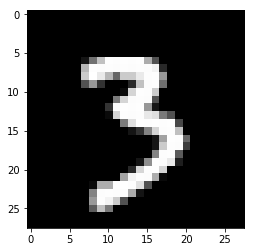

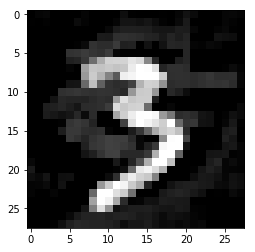

In [567]:
i = 4
plt.imshow(X_37_test[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()

In [568]:
np.sqrt(np.sum((X_37_test[:5] - X_adv)**2, (1,2,3)))

array([7.69212263, 8.73673037, 0.84017921, 2.39951935, 2.83094509])

In [24]:
attack = AttackV3(sess, model, 
                  [l1_rep, l2_rep, l3_rep, l4_rep], 
                  X_train, rep_train_nm, y_train, 
                  pert_norm=np.inf,
                  batch_size=32, 
                  min_dist=min_dist,
                  pert_bound=0.3,
                  m=500, 
                  target_nn=38)

rep:  [<tf.Tensor 'truediv:0' shape=(32, 1, 12544) dtype=float32>, <tf.Tensor 'truediv_1:0' shape=(32, 1, 6272) dtype=float32>, <tf.Tensor 'truediv_2:0' shape=(32, 1, 1152) dtype=float32>, <tf.Tensor 'truediv_3:0' shape=(32, 1, 10) dtype=float32>]
dist:  Tensor("norm_7/Sqrt:0", shape=(32, 500, 1), dtype=float32)
sigmoid:  Tensor("truediv_8:0", shape=(32, 500, 1), dtype=float32)
weights:  Tensor("mul_10:0", shape=(32, 500, 1), dtype=float32)
loss:  Tensor("Sum_5:0", shape=(32,), dtype=float32)
nn_loss:  Tensor("add_8:0", shape=(32,), dtype=float32)


In [ ]:
X_adv = attack.attack(X_37_test, y_37_test)

Running Baseline Attack on instance 0 of 1888
  Finding nn representation as target...
[0.002 0.006 0.35  0.144 0.078 0.06  0.016 0.018 0.7   0.222 0.028 0.616
 0.182 0.086 0.006 0.268 0.114 0.018 0.696 0.26  0.006 0.206 0.136 0.136
 0.712 0.288 0.228 0.272 0.644 0.2   0.038 0.328]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 303.337769
  Number of iterations: 3978
  Number of functions evaluations: 3992
Running Baseline Attack on instance 32 of 1888
  Finding nn representation as target...
[0.132 0.286 0.116 0.172 0.828 0.924 0.12  0.666 0.014 0.174 0.002 0.112
 0.256 0.21  0.49  0.888 0.024 0.24  0.004 0.046 0.164 0.442 0.262 0.338
 0.242 0.182 0.374 0.126 0.142 0.042 0.38  0.016]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 237.400604
  Number of iterations: 1529
  Number of functions evaluations: 1549
R

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 237.117310
  Number of iterations: 5621
  Number of functions evaluations: 5662
Running Baseline Attack on instance 544 of 1888
  Finding nn representation as target...
[0.248 0.002 0.112 0.576 0.436 0.344 0.15  0.868 0.348 0.808 0.37  0.73
 0.026 0.12  0.002 0.024 0.038 0.198 0.724 0.294 0.194 0.042 0.102 0.214
 0.14  0.042 0.54  0.036 0.062 0.226 0.418 0.192]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 235.618835
  Number of iterations: 2763
  Number of functions evaluations: 2781
Running Baseline Attack on instance 576 of 1888
  Finding nn representation as target...
[0.12  0.002 0.864 0.    0.016 0.074 0.082 0.304 0.25  0.162 0.362 0.048
 0.352 0.112 0.06  0.492 0.806 0.472 0.102 0.246 0.396 0.004 0.148 0.18
 0.964 0.388 0.672 0.01  0.006 0.812 0.894 0.03 ]
INFO:tensorflow:O

In [32]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test, query, y_train)
print(acc)

0.0026483050847457626


In [33]:
model.evaluate(X_adv, y_37_test)

1888/1888 [==============================] - 1s 465us/step


[6.7309036820621815, 0.0]

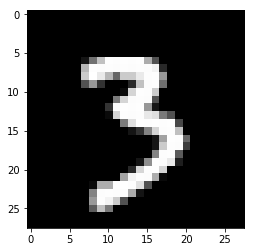

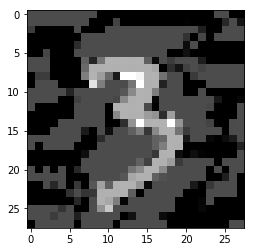

In [34]:
i = 4
plt.imshow(X_37_test[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()

---

## AttackV4

In [57]:
class AttackV4(object):
    
    def __init__(self, sess, model, get_rep, X, X_rep, y_X, 
                 pert_norm=np.inf, batch_size=1000, lr=1e-3, 
                 abort_early=True, init_const=1, pert_bound=0.3,
                 min_dist=None, m=100, target_nn=38):
        """
        X_rep must be normalized and flattened
        m: (int) number of neighbors to consider
        """
    
        self.sess = sess
        self.model = model
        self.X = X
        self.X_rep = X_rep
        self.y_X = y_X
        self.n_layers = len(X_rep)
        self.batch_size = batch_size
        self.abort_early = abort_early
        self.init_const = init_const
        self.pert_norm = pert_norm
        self.pert_bound = pert_bound
        # If min_dist is not given, assign arbritary number
        if min_dist is None:
            min_dist = [0.1]*self.n_layers
        self.min_dist = min_dist
        self.m = m
        self.target_nn = target_nn
        
        assert self.n_layers == len(get_rep)
        
        input_ndim = X.ndim
        input_axis = np.arange(1, input_ndim)
        input_shape = (batch_size, ) + X.shape[1:]

        
        # =============== Set up variables and placeholders =============== #
        # Objective variable
        modifier = tf.Variable(np.zeros(input_shape), dtype=tf.float32)

        # These are variables to be more efficient in sending data to tf
        q_var = tf.Variable(np.zeros(input_shape), dtype=tf.float32, name='q_var')
        x_var = []
        for l in range(self.n_layers):
            rep_shape = (batch_size, m, X_rep[l].shape[1])
            x_var.append(tf.Variable(np.zeros(rep_shape), 
                                     dtype=tf.float32, 
                                     name='x_var_{}'.format(l)))
        w_var = tf.Variable(np.zeros((batch_size, m, 1)), 
                            dtype=tf.float32, 
                            name='w_var_{}'.format(l))
        const_var = tf.Variable(
            np.zeros(batch_size), dtype=tf.float32, name='const_var')
        steep_var = tf.Variable(
            np.zeros((batch_size, 1, 1)), dtype=tf.float32, name='const_var')

        # and here's what we use to assign them
        self.assign_q = tf.placeholder(tf.float32, input_shape, name='assign_q')
        self.assign_x = []
        for l in range(self.n_layers):
            rep_shape = (batch_size, m, X_rep[l].shape[1])
            self.assign_x.append(tf.placeholder(tf.float32, 
                                                rep_shape, 
                                                name='assign_x_{}'.format(l)))
        self.assign_w = tf.placeholder(
            tf.float32, [batch_size, m, 1], name='assign_w_{}'.format(l))
        self.assign_const = tf.placeholder(
            tf.float32, [batch_size], name='assign_const')
        self.assign_steep = tf.placeholder(
            tf.float32, [batch_size, 1, 1], name='assign_steep')

        
        # ================= Get reprentation tensor ================= #
        # Clip to ensure pixel value is between 0 and 1
        self.new_q = tf.clip_by_value(q_var + modifier, 0., 1.)
        self.rep = []
        for l in range(self.n_layers):
            rep = get_rep[l](self.new_q)
            rep = tf.reshape(rep, [batch_size, 1, -1])
            rep = rep / tf.norm(rep, axis=2, keepdims=True)
            self.rep.append(rep)

        # L2 perturbation loss
        l2dist = tf.reduce_sum(tf.square(modifier), input_axis)
        self.l2dist = tf.maximum(0., l2dist - self.pert_bound**2)
        
        
        # ================== Approximate NN loss ================== #
        def sigmoid(x, a=1):
            return 1/(1 + tf.exp(-a*x))
        
        self.nn_loss = 0
        for l in range(self.n_layers):
            dist = tf.norm(self.rep[l] - x_var[l], axis=2, keepdims=True)
            self.nn_loss += tf.reduce_sum(
                w_var * sigmoid(min_dist[l] - dist, steep_var), (1, 2))
        
        
        # ==================== Setup optimizer ==================== #
        start_vars = set(x.name for x in tf.global_variables())
        if pert_norm == 2:
            # For L-2 norm constraint, we use Adam optimizer with
            # a penalty term
            self.loss = tf.reduce_mean(const_var*self.nn_loss + self.l2dist)
            optimizer = tf.train.AdamOptimizer(lr)
            self.train_step = optimizer.minimize(self.loss, var_list=[modifier])
        elif pert_norm == np.inf:
            # For L-inf norm constraint, we use L-BFGS-B optimizer 
            # to provide correct bound, optimizer setup is moved to attack()
            self.loss = tf.reduce_mean(self.nn_loss)
            self.modifier = modifier
        else:
            raise ValueError('Invalid choice for perturbation norm!')
            
            
        # DEBUG
        self.dist = dist
        self.rep_db = rep
        self.gradient = tf.gradients(self.nn_loss, modifier)
        print('rep: ', self.rep)
        # dist: (batch_size, m, 1)
        print('dist: ', dist)
        # sigmoid: (batch_size, m, 1)
        print('sigmoid: ', sigmoid(min_dist[l] - dist, steep_var))
        # weights: (batch_size, m, 1)
        print('weights: ', w_var * sigmoid(min_dist[l] - dist, steep_var))
        # loss, nn_loss: (batch_size, )
        print('loss: ', tf.reduce_sum(
            w_var * sigmoid(min_dist[l] - dist, steep_var), (1, 2)))
        print('nn_loss: ', self.nn_loss)
        
            
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        self.setup = []
        self.setup.append(q_var.assign(self.assign_q))
        self.setup.extend([x_var[l].assign(self.assign_x[l]) 
                           for l in range(self.n_layers)])
        self.setup.append(w_var.assign(self.assign_w))
        self.setup.append(steep_var.assign(self.assign_steep))
        self.setup.append(const_var.assign(self.assign_const))
        self.init = tf.variables_initializer(var_list=[modifier] + new_vars)
        
        
    def attack(self, Q, y_Q, bin_search_steps=5, max_iter=200):
        r = []
        for i in range(0, len(Q), self.batch_size):
            print("Running Baseline Attack on instance {} of {}".format(
                i, len(Q)))
            r.extend(self.attack_batch(Q[i:i + self.batch_size],
                                       y_Q[i:i + self.batch_size],
                                       bin_search_steps=bin_search_steps,
                                       max_iter=max_iter))
        return np.array(r)

        
    def attack_batch(self, Q, y_Q, bin_search_steps=5, max_iter=200):   
        
        # Find closest rep of different class
        print("  Finding nn representation as target...")
        
        # TODO: 
        # nn = find_nn_diff_class_l2(Q, y_Q, self.X, self.y_X, self.m)
        # nn = find_nn_l2(Q, self.X, self.m)
        nn = find_2nd_nn_l2(Q, self.X, self.m)
        
        rep_m = [np.squeeze(rep[nn]) for rep in self.X_rep]
        
        # Get weights w
        w = 2*(self.y_X[nn] == y_Q[:, np.newaxis]).astype(np.float32) - 1
        print(np.mean(w == -1, axis=1))
        
        # Initialize steep
        steep = np.ones((self.batch_size, 1, 1))
        
        # Find nn to target rep to save nn search time during optimization
        # check_rep = find_nn(target_rep, self.X_rep, 100)
        
        # ============ Optimizing with L-inf norm constraints =========== #
        # L-BFGS-B optimizer only needs to be called once
        if self.pert_norm == np.inf:
            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            const = np.ones(self.batch_size) * self.init_const
            
            # Set the variables so that we don't have to send them over again
            setup_dict = {self.assign_q: Q_batch,
                          self.assign_w: w[:, :, np.newaxis],
                          self.assign_const: const,
                          self.assign_steep: steep}
            for l in range(self.n_layers):
                setup_dict[self.assign_x[l]] = rep_m[l]
            self.sess.run(self.setup, feed_dict=setup_dict)
            
            # Set up variables bound and optimizer
            upper_bound = np.minimum(self.pert_bound, 1 - Q_batch)
            lower_bound = np.maximum(-self.pert_bound, -Q_batch)
            var_to_bounds = {self.modifier: (lower_bound, upper_bound)}
            optimizer = tf.contrib.opt.ScipyOptimizerInterface(
                self.loss, 
                var_list=[self.modifier], 
                var_to_bounds=var_to_bounds, 
                method='L-BFGS-B')
            
            # Call optimizer
            optimizer.minimize(self.sess)
            return self.sess.run(self.new_q)
            
        # ============= Optimizing with L2 norm constraints ============ #
        o_bestl2 = [1e9] * self.batch_size
        o_bestadv = np.zeros_like(Q[:self.batch_size])
        
        # Set the lower and upper bounds
        lower_bound = np.zeros(self.batch_size)
        const = np.ones(self.batch_size) * self.init_const
        upper_bound = np.ones(self.batch_size) * 1e9
       
        for outer_step in range(bin_search_steps):

            self.sess.run(self.init)
            Q_batch = Q[:self.batch_size]
            
            bestl2 = [1e9] * self.batch_size
            bestadv = np.zeros_like(Q_batch)
            print("  Binary search step {} of {}".format(
                outer_step, bin_search_steps))

            # Set the variables so that we don't have to send them over again
            setup_dict = {self.assign_q: Q_batch,
                          self.assign_w: w[:, :, np.newaxis],
                          self.assign_const: const,
                          self.assign_steep: steep}
            for l in range(self.n_layers):
                setup_dict[self.assign_x[l]] = rep_m[l]
            self.sess.run(self.setup, feed_dict=setup_dict)

            prev = 1e6
            for iteration in range(max_iter):
                # Take one step in optimization
                _, l, l2s, dls, reps, qs = self.sess.run([self.train_step, 
                                                          self.loss, 
                                                          self.l2dist,
                                                          self.nn_loss,
                                                          self.rep, 
                                                          self.new_q])
                # DEBUG
#                 print(self.sess.run(self.dist))
#                 grad = self.sess.run(self.gradient)
#                 print(grad)
#                 rep = self.sess.run(self.rep_db)
#                 print(rep.shape)
#                 print(np.sum(rep**2, axis=2))
                
                if iteration % ((max_iter // 10) or 1) == 0:
                    print(("    Iteration {} of {}: loss={:.3g} l2={:.3g}").format(
                        iteration, max_iter, l, np.mean(l2s)))
                
                # Abort early if stop improving
                if self.abort_early and iteration % ((max_iter // 10) or 1) == 0:
                    if l > prev * .9999:
                        print("    Failed to make progress; stop early")
                        break
                    prev = l
                
                # Check termination condition
                # nn = find_nn(reps, self.X_rep, 1)
                # y_pred = classify(nn, self.y_X)
                # suc_ind = np.where(y_pred != y_Q)[0]
                # suc_ind = np.where(dls <= 1e-1)[0]
                if (iteration + 1) % 10 == 0:
                    p, _ = dknn_acc(A, get_all_rep_nm(qs), y_Q, query, self.y_X)
                    suc_ind = np.where(np.argmax(p, 1) != y_Q)[0]
                    for ind in suc_ind:
                        if l2s[ind] < bestl2[ind]:
                            bestl2[ind] = l2s[ind]
                            bestadv[ind] = qs[ind]
                        
            # Adjust const according to results
            for e in range(self.batch_size):
                if bestl2[e] < 1e9:
                    # Success, divide const by two
                    upper_bound[e] = min(upper_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    if bestl2[e] < o_bestl2[e]:
                        o_bestl2[e] = bestl2[e]
                        o_bestadv[e] = bestadv[e]
                else:
                    # Failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    else:
                        const[e] *= 10
                        
        return o_bestadv

In [21]:
def find_2nd_nn_l2(Q, y_Q, X, y_X, k):
    assert Q.shape[1:] == X.shape[1:]
    nn = np.zeros((len(Q), k), dtype=np.int32)
    axis = tuple(np.arange(1, X.ndim, dtype=np.int32))
    for i, q in enumerate(Q):
        dist = np.sum((X - q)**2, axis=axis)
        ind = np.argsort(dist)
        mean_dist = np.zeros((10,))
        for j in range(10):
            ind_j = ind[y_X[ind] == j]
            dist_j = dist[ind_j][:k]
            mean_dist[j] = np.mean(dist_j)
        ind_dist = np.argsort(mean_dist)
        if ind_dist[0] == y_Q[i]:
            nn[i] = ind[y_X[ind] == ind_dist[1]][:k]
        else:
            nn[i] = ind[y_X[ind] == ind_dist[0]][:k]
    return nn

In [75]:
attack = AttackV4(sess, model, 
                  [l1_rep, l2_rep, l3_rep, l4_rep], 
                  X_train, rep_train_nm, y_train, 
                  pert_norm=np.inf,
                  batch_size=5, 
                  min_dist=[0.1, 0.1, 0.1, 0.1],
                  pert_bound=0.3,
                  m=500, 
                  target_nn=38)

rep:  [<tf.Tensor 'truediv_22:0' shape=(5, 1, 12544) dtype=float32>, <tf.Tensor 'truediv_23:0' shape=(5, 1, 6272) dtype=float32>, <tf.Tensor 'truediv_24:0' shape=(5, 1, 1152) dtype=float32>, <tf.Tensor 'truediv_25:0' shape=(5, 1, 10) dtype=float32>]
dist:  Tensor("norm_23/Sqrt:0", shape=(5, 500, 1), dtype=float32)
sigmoid:  Tensor("truediv_30:0", shape=(5, 500, 1), dtype=float32)
weights:  Tensor("mul_36:0", shape=(5, 500, 1), dtype=float32)
loss:  Tensor("Sum_17:0", shape=(5,), dtype=float32)
nn_loss:  Tensor("add_32:0", shape=(5,), dtype=float32)


In [76]:
X_adv = attack.attack(X_37_test[:5], y_37_test[:5])

Running Baseline Attack on instance 0 of 5
  Finding nn representation as target...
[1. 1. 1. 1. 1.]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -732.149109
  Number of iterations: 259
  Number of functions evaluations: 276


In [77]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test[:5], query, y_train)
print(acc)
print(np.argmax(p, 1))

0.0
[9 9 5 9 5]


In [78]:
np.max(p, 1)

array([0.16666667, 0.08666667, 0.1       , 0.26133333, 0.132     ])

In [79]:
p

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.16666667],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00133333, 0.        , 0.08666667],
       [0.        , 0.        , 0.        , 0.00133333, 0.        ,
        0.1       , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.26133333],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.132     , 0.        , 0.        , 0.        , 0.        ]])

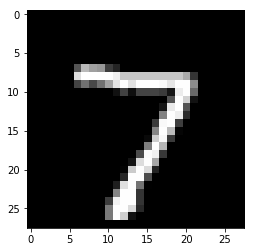

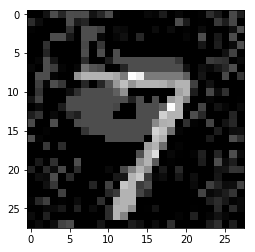

In [84]:
i = 0
plt.imshow(X_37_test[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()

In [71]:
p, acc = dknn_acc(A, get_all_rep_nm(X_37_test[:5]), y_37_test[:5], query, y_train)
print(acc)
print(np.argmax(p, 1))

1.0
[7 7 3 7 3]


In [74]:
p

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.044     , 0.        ,
        0.00266667, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

---

## AttackV5

In [22]:
class AttackV5(object):
    
    def __init__(self, sess, model, get_rep, X, X_rep, y_X, 
                 pert_norm=np.inf, batch_size=1000, lr=1e-3, 
                 abort_early=True, init_const=1, pert_bound=0.3,
                 min_dist=None, m=100, target_nn=38):
        """
        X_rep must be normalized and flattened
        m: (int) number of neighbors to consider
        """
    
        self.sess = sess
        self.model = model
        self.X = X
        self.X_rep = X_rep
        self.y_X = y_X
        self.n_layers = len(X_rep)
        self.batch_size = batch_size
        self.abort_early = abort_early
        self.init_const = init_const
        self.pert_norm = pert_norm
        self.pert_bound = pert_bound
        # If min_dist is not given, assign arbritary number
        if min_dist is None:
            min_dist = [0.1]*self.n_layers
        self.min_dist = min_dist
        self.m = m
        self.target_nn = target_nn
        
        assert self.n_layers == len(get_rep)
        
        input_ndim = X.ndim
        input_axis = np.arange(1, input_ndim)
        input_shape = (batch_size, ) + X.shape[1:]

        
        # =============== Set up variables and placeholders =============== #
        # Objective variable
        modifier = tf.Variable(np.zeros(input_shape), dtype=tf.float32)

        # These are variables to be more efficient in sending data to tf
        q_var = tf.Variable(np.zeros(input_shape), dtype=tf.float32, name='q_var')
        x_var = []
        for l in range(self.n_layers):
            rep_shape = (batch_size, m, X_rep[l].shape[1])
            x_var.append(tf.Variable(np.zeros(rep_shape), 
                                     dtype=tf.float32, 
                                     name='x_var_{}'.format(l)))
        w_var = tf.Variable(np.zeros((batch_size, m, 1)), 
                            dtype=tf.float32, 
                            name='w_var_{}'.format(l))
        const_var = tf.Variable(
            np.zeros(batch_size), dtype=tf.float32, name='const_var')
        steep_var = tf.Variable(
            np.zeros((batch_size, 1, 1)), dtype=tf.float32, name='const_var')
        clipmin_var = tf.Variable(
            np.zeros(input_shape), dtype=tf.float32, name='clipmin_var')
        clipmax_var = tf.Variable(
            np.zeros(input_shape), dtype=tf.float32, name='clipmax_var')

        # and here's what we use to assign them
        self.assign_q = tf.placeholder(tf.float32, input_shape, name='assign_q')
        self.assign_x = []
        for l in range(self.n_layers):
            rep_shape = (batch_size, m, X_rep[l].shape[1])
            self.assign_x.append(tf.placeholder(tf.float32, 
                                                rep_shape, 
                                                name='assign_x_{}'.format(l)))
        self.assign_w = tf.placeholder(
            tf.float32, [batch_size, m, 1], name='assign_w_{}'.format(l))
        self.assign_const = tf.placeholder(
            tf.float32, [batch_size], name='assign_const')
        self.assign_steep = tf.placeholder(
            tf.float32, [batch_size, 1, 1], name='assign_steep')
        self.assign_clipmin = tf.placeholder(
            tf.float32, input_shape, name='assign_clipmin')
        self.assign_clipmax = tf.placeholder(
            tf.float32, input_shape, name='assign_clipmax')

        
        # ================= Get reprentation tensor ================= #
        # Clip to ensure pixel value is between 0 and 1
        self.new_q = (tf.tanh(modifier + q_var) + 1) / 2
        self.new_q = self.new_q * (clipmax_var - clipmin_var) + clipmin_var
        # Distance to the input data
        orig = (tf.tanh(q_var) + 1) / \
            2 * (clipmax_var - clipmin_var) + clipmin_var
        self.rep = []
        for l in range(self.n_layers):
            rep = get_rep[l](self.new_q)
            rep = tf.reshape(rep, [batch_size, 1, -1])
            rep = rep / tf.norm(rep, axis=2, keepdims=True)
            self.rep.append(rep)

        # L2 perturbation loss
        l2dist = tf.reduce_sum(tf.square(self.new_q - orig), input_axis)
        self.l2dist = tf.maximum(0., l2dist - self.pert_bound**2)
        
        
        # ================== Approximate NN loss ================== #
        def sigmoid(x, a=1):
            return 1/(1 + tf.exp(-a*x))
        
        self.nn_loss = 0
        for l in range(self.n_layers):
            dist = tf.norm(self.rep[l] - x_var[l], axis=2, keepdims=True)
            self.nn_loss += tf.reduce_sum(
                w_var * sigmoid(min_dist[l] - dist, steep_var), (1, 2))
        
        
        # ==================== Setup optimizer ==================== #
        start_vars = set(x.name for x in tf.global_variables())
        if pert_norm == 2 or pert_norm == np.inf:
            # For L-2 norm constraint, we use a penalty term
            self.loss = tf.reduce_mean(const_var*self.nn_loss + self.l2dist)
        elif pert_norm == np.inf:
            # For L-inf norm constraint, we do not use penalty term as
            # change of variable provides box constraint
            self.loss = tf.reduce_mean(self.nn_loss)
        else:
            raise ValueError('Invalid choice for perturbation norm!')
        optimizer = tf.train.AdamOptimizer(lr)
        self.train_step = optimizer.minimize(self.loss, var_list=[modifier])  
            
        # DEBUG
        self.dist = dist
        self.rep_db = rep
        self.gradient = tf.gradients(self.nn_loss, modifier)
        print('rep: ', self.rep)
        # dist: (batch_size, m, 1)
        print('dist: ', dist)
        # sigmoid: (batch_size, m, 1)
        print('sigmoid: ', sigmoid(min_dist[l] - dist, steep_var))
        # weights: (batch_size, m, 1)
        print('weights: ', w_var * sigmoid(min_dist[l] - dist, steep_var))
        # loss, nn_loss: (batch_size, )
        print('loss: ', tf.reduce_sum(
            w_var * sigmoid(min_dist[l] - dist, steep_var), (1, 2)))
        print('nn_loss: ', self.nn_loss)
        
            
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        self.setup = []
        self.setup.append(q_var.assign(self.assign_q))
        self.setup.extend([x_var[l].assign(self.assign_x[l]) 
                           for l in range(self.n_layers)])
        self.setup.append(w_var.assign(self.assign_w))
        self.setup.append(steep_var.assign(self.assign_steep))
        self.setup.append(const_var.assign(self.assign_const))
        self.setup.append(clipmin_var.assign(self.assign_clipmin))
        self.setup.append(clipmax_var.assign(self.assign_clipmax))
        self.init = tf.variables_initializer(var_list=[modifier] + new_vars)
        
        
    def attack(self, Q, y_Q, bin_search_steps=5, max_iter=200, 
               rnd_start=0):
        r = []
        for i in range(0, len(Q), self.batch_size):
            print("Running Baseline Attack on instance {} of {}".format(
                i, len(Q)))
            t1 = timeit.default_timer()
            Q_batch = Q[i:i + self.batch_size]
            y_batch = y_Q[i:i + self.batch_size]
            real_len = Q_batch.shape[0]
            if real_len != self.batch_size:
                pad_Q = ((0, self.batch_size - real_len), (0, 0), (0, 0), (0, 0))
                pad_y = ((0, self.batch_size - real_len))
                Q_batch = np.pad(Q_batch, pad_Q, 'constant')
                y_batch = np.pad(y_batch, pad_y, 'constant')
            r.extend(self.attack_batch(Q_batch,
                                       y_batch,
                                       bin_search_steps=bin_search_steps,
                                       max_iter=max_iter,
                                       rnd_start=rnd_start))
            t2 = timeit.default_timer()
            print("Time this batch: {:.0f}s".format(t2 - t1))
        return np.array(r)

        
    def attack_batch(self, Q, y_Q, bin_search_steps=5, max_iter=200,
                     rnd_start=0):   
        
        # Find closest rep of different class
        print("  Finding nn representation as target...")
        
        # TODO: 
        # nn = find_nn_diff_class_l2(Q, y_Q, self.X, self.y_X, self.m)
        # nn = find_nn_l2(Q, self.X, self.m)
        nn = find_2nd_nn_l2(Q, y_Q, self.X, self.y_X, self.m)
        
        rep_m = [np.squeeze(rep[nn]) for rep in self.X_rep]
        
        # Get weights w
        w = 2*(self.y_X[nn] == y_Q[:, np.newaxis]).astype(np.float32) - 1
        print(np.mean(w == -1, axis=1))
        
        # Initialize steep
        steep = np.ones((self.batch_size, 1, 1))
        
        # Find nn to target rep to save nn search time during optimization
        # check_rep = find_nn(target_rep, self.X_rep, 100)
        
        o_bestl2 = [1e9] * self.batch_size
        o_bestadv = np.zeros_like(Q[:self.batch_size])
        
        # Set the lower and upper bounds
        lower_bound = np.zeros(self.batch_size)
        const = np.ones(self.batch_size) * self.init_const
        upper_bound = np.ones(self.batch_size) * 1e9
       
        for outer_step in range(bin_search_steps):
            
            noise = rnd_start * np.random.rand(*Q.shape)
            Q_tanh = np.clip(Q + noise, 0., 1.)

            # Calculate bound with L-inf norm constraints
            if self.pert_norm == np.inf:
                # Re-scale instances to be within range [x-d, x+d]
                # for d is pert_bound
                clipmin = np.clip(Q_tanh - self.pert_bound, 0., 1.)
                clipmax = np.clip(Q_tanh + self.pert_bound, 0., 1.)

            # Calculate bound with L2 norm constraints
            elif self.pert_norm == 2:
            # Re-scale instances to be within range [0, 1]
                clipmin = np.zeros_like(Q_tanh)
                clipmax = np.ones_like(Q_tanh)
            
            Q_tanh = (Q_tanh - clipmin) / (clipmax - clipmin)
            Q_tanh = (Q_tanh * 2) - 1
            Q_tanh = np.arctanh(Q_tanh * .999999)
            Q_batch = Q_tanh[:self.batch_size]
            
            bestl2 = [1e9] * self.batch_size
            bestadv = np.zeros_like(Q_batch)
            print("  Binary search step {} of {}".format(
                outer_step, bin_search_steps))
            
            # Set the variables so that we don't have to send them over again
            self.sess.run(self.init)
            setup_dict = {self.assign_q: Q_batch,
                          self.assign_w: w[:, :, np.newaxis],
                          self.assign_const: const,
                          self.assign_steep: steep,
                          self.assign_clipmin: clipmin,
                          self.assign_clipmax: clipmax}
            for l in range(self.n_layers):
                setup_dict[self.assign_x[l]] = rep_m[l]
            self.sess.run(self.setup, feed_dict=setup_dict)

            prev = 1e6
            for iteration in range(max_iter):
                # Take one step in optimization
                _, l, l2s, qs = self.sess.run([self.train_step, 
                                               self.loss, 
                                               self.l2dist,
                                               self.new_q])
                # DEBUG
#                 print(self.sess.run(self.dist))
#                 grad = self.sess.run(self.gradient)
#                 print(grad)
#                 print(np.max(qs[0]))
#                 print(np.min(qs[0]))
#                 rep = self.sess.run(self.rep_db)
#                 print(rep.shape)
#                 print(np.sum(rep**2, axis=2))
                
                if iteration % ((max_iter // 10) or 1) == 0:
                    print(("    Iteration {} of {}: loss={:.3g} l2={:.3g}").format(
                        iteration, max_iter, l, np.mean(l2s)))
                
                # Abort early if stop improving
                if self.abort_early and iteration % ((max_iter // 10) or 1) == 0:
                    if l > prev * .9999:
                        print("    Failed to make progress; stop early")
                        break
                    prev = l
                
                # Check success of adversarial examples
                if iteration % ((max_iter // 10) or 1) == 0:
                    p, _ = dknn_acc(A, get_all_rep_nm(qs), y_Q, query, self.y_X)
                    suc_ind = np.where(np.argmax(p, 1) != y_Q)[0]
                    for ind in suc_ind:
                        if l2s[ind] < bestl2[ind]:
                            bestl2[ind] = l2s[ind]
                            bestadv[ind] = qs[ind]
                        
            # Adjust const according to results
            for e in range(self.batch_size):
                if bestl2[e] < 1e9:
                    # Success, divide const by two
                    upper_bound[e] = min(upper_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    if bestl2[e] < o_bestl2[e]:
                        o_bestl2[e] = bestl2[e]
                        o_bestadv[e] = bestadv[e]
                else:
                    # Failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e], const[e])
                    if upper_bound[e] < 1e9:
                        const[e] = (lower_bound[e] + upper_bound[e]) / 2
                    else:
                        const[e] *= 10
        
        # Also save unsuccessful samples
        ind = np.where(o_bestl2 == 1e9)[0]
        o_bestadv[ind] = qs[ind]

        return o_bestadv

In [29]:
attack = AttackV5(sess, model, 
                  [l1_rep, l2_rep, l3_rep, l4_rep], 
                  X_train, rep_train_nm, y_train, 
                  pert_norm=2,
                  batch_size=80, 
                  lr=1e-1,
                  min_dist=min_dist,
                  pert_bound=0.,
                  m=500, 
                  target_nn=38)

rep:  [<tf.Tensor 'truediv_15:0' shape=(80, 1, 12544) dtype=float32>, <tf.Tensor 'truediv_16:0' shape=(80, 1, 6272) dtype=float32>, <tf.Tensor 'truediv_17:0' shape=(80, 1, 1152) dtype=float32>, <tf.Tensor 'truediv_18:0' shape=(80, 1, 10) dtype=float32>]
dist:  Tensor("norm_15/Sqrt:0", shape=(80, 500, 1), dtype=float32)
sigmoid:  Tensor("truediv_23:0", shape=(80, 500, 1), dtype=float32)
weights:  Tensor("mul_29:0", shape=(80, 500, 1), dtype=float32)
loss:  Tensor("Sum_11:0", shape=(80,), dtype=float32)
nn_loss:  Tensor("add_29:0", shape=(80,), dtype=float32)


In [30]:
X_adv = attack.attack(X_37_test, y_37_test)

Running Baseline Attack on instance 0 of 1888
  Finding nn representation as target...
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
  Binary search step 0 of 5


ResourceExhaustedError: OOM when allocating tensor with shape[80,500,12544] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Assign_19 = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=false, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](x_var_0_3, _arg_assign_x_0_1_0_6/_2311)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Assign_19/_2321 = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_54_Assign_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Assign_19', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-f79a1529055a>", line 10, in <module>
    target_nn=38)
  File "<ipython-input-22-b9e6d3f2e52a>", line 147, in __init__
    for l in range(self.n_layers)])
  File "<ipython-input-22-b9e6d3f2e52a>", line 147, in <listcomp>
    for l in range(self.n_layers)])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 645, in assign
    return state_ops.assign(self._variable, value, use_locking=use_locking)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/state_ops.py", line 216, in assign
    validate_shape=validate_shape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[80,500,12544] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Assign_19 = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=false, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](x_var_0_3, _arg_assign_x_0_1_0_6/_2311)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Assign_19/_2321 = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_54_Assign_19", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [131]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test[:5], query, y_train)
print(acc)
print(np.argmax(p, 1))

0.0
[9 9 5 9 5]


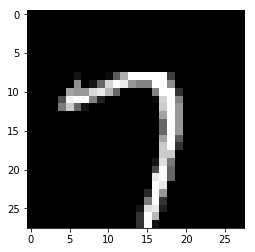

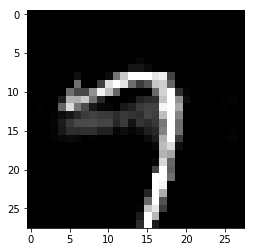

In [136]:
i = 3
plt.imshow(X_37_test[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()

In [112]:
attack = AttackV5(sess, model, 
                  [l1_rep, l2_rep, l3_rep, l4_rep], 
                  X_train, rep_train_nm, y_train, 
                  pert_norm=np.inf,
                  batch_size=5, 
                  lr=1e-3,
                  min_dist=min_dist,
                  pert_bound=0.3,
                  m=500, 
                  target_nn=38)

rep:  [<tf.Tensor 'truediv_89:0' shape=(5, 1, 12544) dtype=float32>, <tf.Tensor 'truediv_90:0' shape=(5, 1, 6272) dtype=float32>, <tf.Tensor 'truediv_91:0' shape=(5, 1, 1152) dtype=float32>, <tf.Tensor 'truediv_92:0' shape=(5, 1, 10) dtype=float32>]
dist:  Tensor("norm_67/Sqrt:0", shape=(5, 500, 1), dtype=float32)
sigmoid:  Tensor("truediv_97:0", shape=(5, 500, 1), dtype=float32)
weights:  Tensor("mul_113:0", shape=(5, 500, 1), dtype=float32)
loss:  Tensor("Sum_47:0", shape=(5,), dtype=float32)
nn_loss:  Tensor("add_112:0", shape=(5,), dtype=float32)


In [113]:
X_adv = attack.attack(X_37_test[:5], y_37_test[:5])

Running Baseline Attack on instance 0 of 5
  Finding nn representation as target...
[1. 1. 1. 1. 1.]
  Binary search step 0 of 5
    Iteration 0 of 200: loss=-784 l2=0
    Iteration 20 of 200: loss=-784 l2=0
    Iteration 40 of 200: loss=-785 l2=0
    Iteration 60 of 200: loss=-786 l2=0
    Iteration 80 of 200: loss=-787 l2=0
    Iteration 100 of 200: loss=-787 l2=0
    Iteration 120 of 200: loss=-788 l2=3.6e-05
    Iteration 140 of 200: loss=-789 l2=0.00627
    Iteration 160 of 200: loss=-789 l2=0.0278
    Iteration 180 of 200: loss=-790 l2=0.0549
  Binary search step 1 of 5
    Iteration 0 of 200: loss=-7.84e+03 l2=0
    Iteration 20 of 200: loss=-7.84e+03 l2=0
    Iteration 40 of 200: loss=-7.85e+03 l2=0
    Iteration 60 of 200: loss=-7.86e+03 l2=0
    Iteration 80 of 200: loss=-7.87e+03 l2=0
    Iteration 100 of 200: loss=-7.87e+03 l2=0
    Iteration 120 of 200: loss=-7.88e+03 l2=3.6e-05
    Iteration 140 of 200: loss=-7.89e+03 l2=0.00659
    Iteration 160 of 200: loss=-7.89e+03 l2

In [114]:
p, acc = dknn_acc(A, get_all_rep_nm(X_adv), y_37_test[:5], query, y_train)
print(acc)
print(np.argmax(p, 1))

0.0
[5 5 5 5 5]


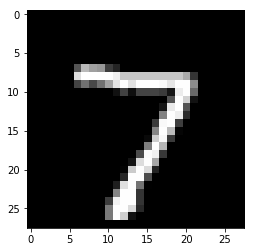

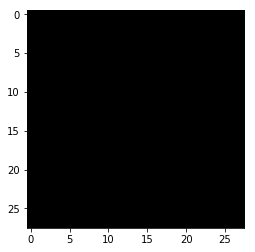

In [116]:
i = 0
plt.imshow(X_37_test[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()

In [142]:
print("a{:.0f}".format(3.5))

a4


In [156]:
a = (np.pad(X_train[0:3], ((0, 1), (0, 0), (0, 0), (0, 0)),'constant', constant_values=0))

In [160]:
np.sum(a[-2])

76.24705882352941

In [161]:
y_train.shape

(60000,)